# IPSLCM6_snow_bias using CLIMAF (script Martin)

In [1]:
from climaf.api import *
import numpy.ma as ma #masked arrays
import datetime
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import xarray as xr

('LC debug :', False)
CliMAF install => /ciclad-home/jservon/Evaluation/CliMAF/climaf_installs/climaf_1.2.12
python => /prodigfs/ipslfs/dods/jservon/miniconda/envs/cesmep_env/bin/python
---
Required softwares to run CliMAF => you are using the following versions/installations:


CliMAF version = 1.2.12


ncl 6.3.0 => /opt/ncl-6.3.0/bin/ncl
cdo 1.9.6 => /opt/nco/1.9/bin/cdo
nco (ncks) 4.5.2 => /opt/nco-4.5.2/bin/ncks
ncdump 4.4.1.1 => /prodigfs/ipslfs/dods/jservon/miniconda/envs/cesmep_env/bin/ncdump
---


Cache directory set to : /data/mlalande/climafcache (use $CLIMAF_CACHE if set) 
Cache directory for remote data set to : /data/mlalande/climafcache/remote_data (use $CLIMAF_REMOTE_CACHE if set) 
Available macros read from ~/.climaf.macros are : []


In [2]:
# The years considered to plot the biases between IPSL and observational references
first_year=1984
last_year=2014

In [3]:
##Redefining clim_average function to choose directly bi monthly means (March-April)
def clim_average_bimon(dat,season):
    if str(season).lower() in ['ann','annual','climato','clim','climatology','annual_average','anm','annual_mean']:
        avg = time_average(dat)
    else:
        #
        # -- Compute the annual cycle
        scyc = annual_cycle(dat)
        #
        # -- Classic atmospheric seasons
        selmonths=selmonth=None
        if str(season).upper()=='DJF': selmonths ='1,2,12'
        if str(season).upper()=='MAM': selmonths ='3,4,5'
        if str(season).upper()=='JJA': selmonths ='6,7,8'
        if str(season).upper()=='SON': selmonths ='9,10,11'
        # -- Snow season
        if str(season).upper()=='MA': selmonths ='3,4'
        if str(season).upper()=='AM': selmonths ='4,5'
        if str(season).upper()=='MJ': selmonths ='5,6'    
        if str(season).upper()=='SO': selmonths ='9,10'
        if str(season).upper()=='ON': selmonths ='10,11'

        if selmonths:
            avg = ccdo(scyc,operator='timmean -seltimestep,'+selmonths)
            #avg = ccdo(scyc,operator='timmean -selmon,'+selmonths
        #
        # -- Annual Maximum
        if str(season).lower() in ['max','annual max','annual_max']:
            avg = ccdo(scyc,operator='timmax')
        #
        # -- Annual Maximum
        if str(season).lower() in ['min','annual min','annual_min']:
            avg = ccdo(scyc,operator='timmin')
    #
    return avg

<type 'instance'>


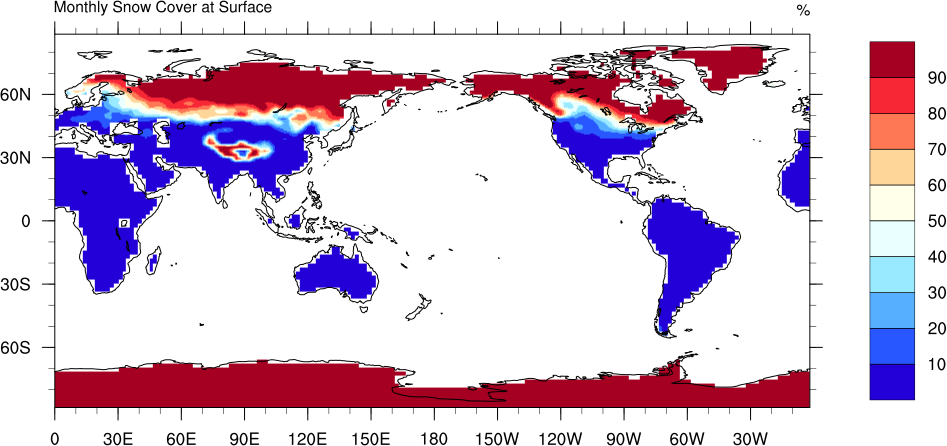

In [4]:
##Loading reference dataset and selecting period
##This is not the "elegant" way to do it, we should work on the creation of projec='ref_climatos'
refnoaa = fds('/home/msantola/TP_CLiMAF/ReferenceSNOW/SNC/SNCRefData/snowc.mon.noaaV2c_185101_201412_2.0x1.75.nc',
           variable='snowc',period=str(first_year)+'-'+str(last_year))
print type(refnoaa)
cfile(refnoaa)
#Computing clim of MA of reference dataset
mean_refnoaa = clim_average_bimon(refnoaa,'MA')
implot(mean_refnoaa)

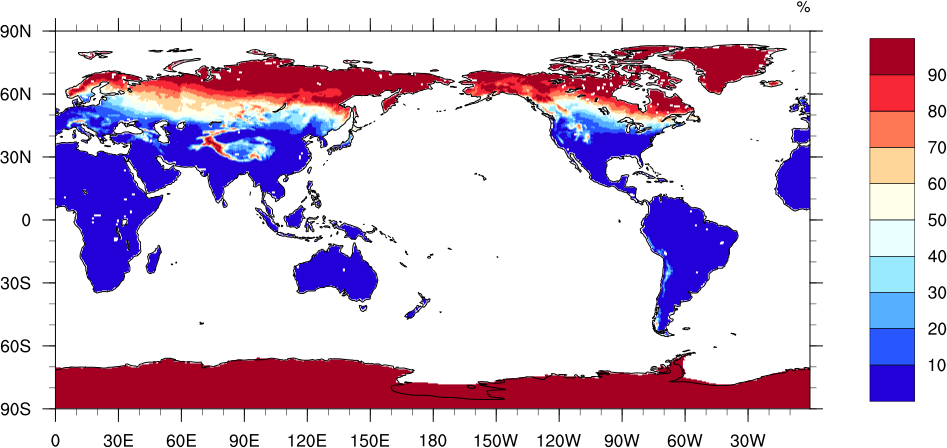

In [5]:
##Loading reference dataset, selecting period and regriding
#NCEP/CFSR reanalysis 
refncep= fds('/home/msantola/TP_CLiMAF/SharedObsSnow/snc_ncarcfsr_1979-2016_0.5x0.5.nc',
           variable='snowc',period=str(first_year)+'-'+str(last_year))
cfile(refncep)
#Computing clim of MAM of reference dataset
masked_refncep=clim_average_bimon(mask(refncep,miss=9999),'MA')
implot(masked_refncep)

In [8]:
projects()

-- Available projects:
-- Project: ref_ts
Facets => ${project}%${simulation}%${variable}%${period}%${domain}%${frequency}%${product}%${obs_type}%${table}
-- Project: CORDEX
Facets => ${project}%${simulation}%${variable}%${period}%${domain}%${root}%${model}%${CORDEX_domain}%${model_version}%${frequency}%${driving_model}%${realization}%${experiment}%${version}%${institute}
-- Project: IGCM_CMIP6
Facets => ${project}%${simulation}%${variable}%${period}%${domain}%${root}%${login}%${IPSL_MODEL}%${status}%${experiment}%${realm}%${frequency}%${table}%${model}%${realization}%${grid}
-- Project: E-OBS
Facets => ${project}%${simulation}%${variable}%${period}%${domain}%${grid}%${frequency}
-- Project: ref_climatos
Facets => ${project}%${simulation}%${variable}%${period}%${domain}%${frequency}%${product}%${clim_period}%${table}%${obs_type}%${clim_period_begin}%${clim_period_end}
-- Project: CORDEX-Adjust
Facets => ${project}%${simulation}%${variable}%${period}%${domain}%${root}%${model}%${CORDEX_d

In [12]:
req_snow = ds(project='CMIP6', model='IPSL-CM6A-LR',
              variable='snc', table="LImon",frequency='monthly',realization='r1i1p1f1',
               period=str(first_year)+'-'+str(last_year),experiment='historical')

In [13]:
summary(req_snow)

/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/LImon/snc/gr/latest/snc_LImon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc


{'domain': 'global',
 'experiment': 'historical',
 'grid': 'g*',
 'institute': '*',
 'mip': '*',
 'model': 'IPSL-CM6A-LR',
 'period': 1984-2014,
 'project': 'CMIP6',
 'realization': 'r1i1p1f1',
 'root': '/bdd',
 'simulation': '',
 'table': 'LImon',
 'variable': 'snc',
 'version': 'latest'}

In [8]:
# -- Compute the climatologies
clim_ipsl = clim_average(req_snow,'ANM')
clim_obs = clim_average(refncep,'ANM')
# -- Then, the bias map
rgrd_dat = regrid(clim_ipsl,clim_obs)
clim_bias = minus(rgrd_dat,clim_obs)

In [9]:
plotting_specs = dict(min=-50, max=50, delta=5, contours=10,
                      focus='land',color='MPL_RdBu'
                     )

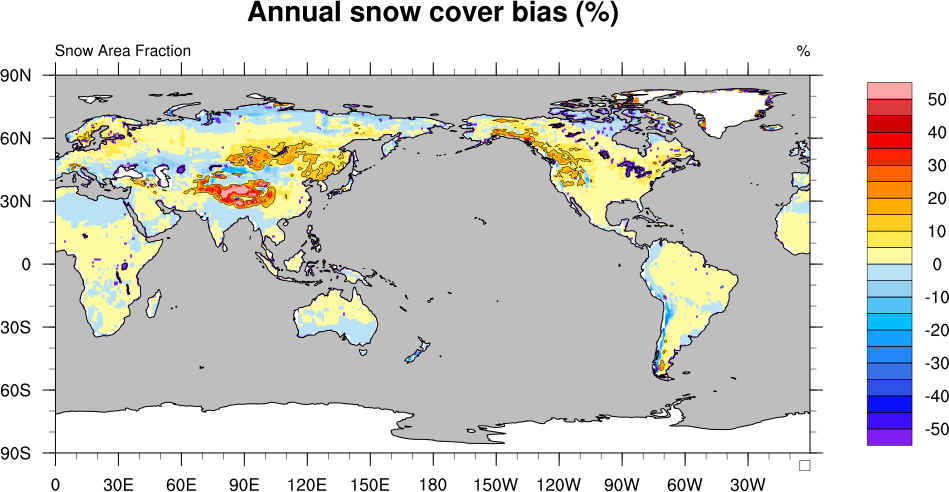

In [10]:
map = plot(clim_bias,title='Annual snow cover bias (%)', **plotting_specs)
# --> a map that you can easily customize.
iplot(map)

In [11]:
# DJF biases
# -- Compute the climatologies
clim_ipsl_DJF = clim_average(req_snow,'DJF')
clim_obs_DJF = clim_average(refncep,'DJF')
# -- Then, the bias map
rgrd_dat_DJF = regrid(clim_ipsl_DJF,clim_obs_DJF)
clim_bias_DJF = minus(rgrd_dat_DJF,clim_obs_DJF)
map_DJF = plot(clim_bias_DJF,title='DJF snow cover bias (%)', **plotting_specs)

In [12]:
# MAM biases
# -- Compute the climatologies
clim_ipsl_MAM = clim_average(req_snow,'MAM')
clim_obs_MAM = clim_average(refncep,'MAM')
# -- Then, the bias map
rgrd_dat_MAM = regrid(clim_ipsl_MAM,clim_obs_MAM)
clim_bias_MAM = minus(rgrd_dat_MAM,clim_obs_MAM)
map_MAM = plot(clim_bias_MAM,title='MAM snow cover bias (%)', **plotting_specs)

In [13]:
# JJA biases
# -- Compute the climatologies
clim_ipsl_JJA = clim_average(req_snow,'JJA')
clim_obs_JJA = clim_average(refncep,'JJA')
# -- Then, the bias map
rgrd_dat_JJA = regrid(clim_ipsl_JJA,clim_obs_JJA)
clim_bias_JJA = minus(rgrd_dat_JJA,clim_obs_JJA)
map_JJA = plot(clim_bias_JJA,title='JJA snow cover bias (%)', **plotting_specs)

In [14]:
# SON biases
# -- Compute the climatologies
clim_ipsl_SON = clim_average(req_snow,'SON')
clim_obs_SON = clim_average(refncep,'SON')
# -- Then, the bias map
rgrd_dat_SON = regrid(clim_ipsl_SON,clim_obs_SON)
clim_bias_SON = minus(rgrd_dat_SON,clim_obs_SON)
map_SON = plot(clim_bias_SON,title='SON snow cover bias (%)', **plotting_specs)

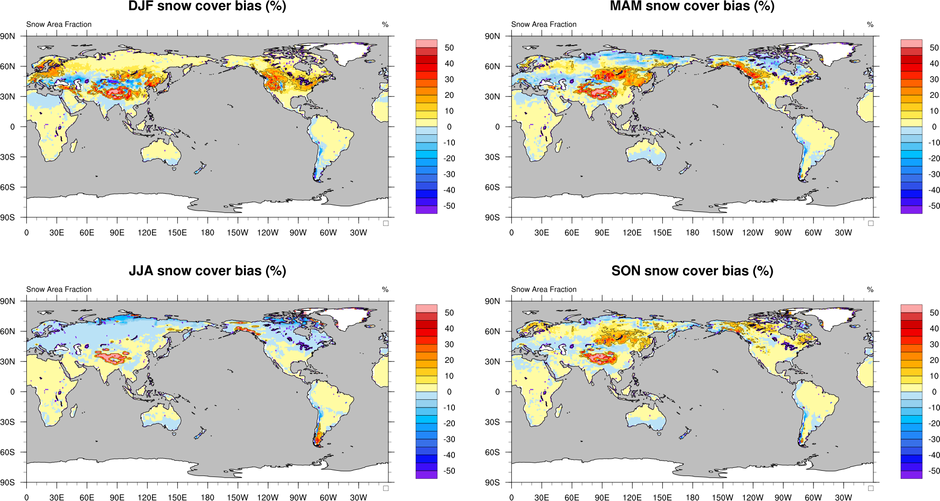

In [15]:
multiplot = cpage(fig_lines = [[map_DJF,map_MAM],[map_JJA,map_SON]])
iplot(multiplot)

In [16]:
#We save the pdf on my home directory:
cfile(cpage(fig_lines=[[map_DJF,map_MAM],[map_JJA,map_SON]]),target='/home/mmenegoz/travaux_martin/snow_IPSLCM6/IPSL_bias_NCEP.pdf')

'/home/mmenegoz/travaux_martin/snow_IPSLCM6/IPSL_bias_NCEP.pdf'

In [17]:
# Rutgers university observations
iyr_obs=1967 # We do not use the first 3 months in the year 1966
fyr_obs=2018 # 2019 is not complete, so it is excluded
variable='snc'
sourceData='/data/mmenegoz/snow_investigations/'

In [18]:
fileName0='nhsce_v01r01_19661004_20190930.nc'
model='rutgersCDR'
resolution='88x88'
fileName=sourceData+fileName0
fh = Dataset(fileName, mode = 'r')
field0= fh.variables['snow_cover_extent'][:]  #when loading, field=field1; mfield=field
xlon = fh.variables['longitude'][:]
nlon=field0.shape[2]
ylat = fh.variables['latitude'][:]
nlat=field0.shape[1]
t=fh.variables['time'][:]
nt=len(t)
landmask=fh.variables['land'][:]
area=fh.variables['area'][:]
print nt #nb of weeks
fh.close()
#
field0=field0*100 # We work in percentage

2765


In [19]:
#We applied the land-sea mask
TF_land=np.ones(field0.shape,dtype=bool)*landmask[None,:,:]
field_dom=ma.array(field0,mask=np.logical_not(TF_land))
area_dom=ma.array(area,mask=np.logical_not(landmask))

In [20]:
# length of the timeseries
years=np.arange(iyr_obs,fyr_obs+1,1)
nyr=len(years)
months=[1,2,3,4,5,6,7,8,9,10,11,12]
nmon=len(months)
tmp=[]

In [21]:
# Weekly -> monthly (Maria trick)
base = datetime.date(1966, 10, 04)
arr = np.array([base + datetime.timedelta(weeks=i) for i in xrange(nt)])
for m in months:
    for y in years:
        for i in range(nt):
            if arr[i].year==y and arr[i].month==m:
                tmp.append(i)
    diff_values=np.diff(tmp)
    split_index = np.where(abs(diff_values) >1)[0]
    split_index += 1
    split_values = np.split(tmp, split_index)
p=[]
for i in range(len(split_values)):
    l=np.ma.mean(field_dom[split_values[i],:,:],axis=0)
    p.append(l)

In [22]:
# p is a list that we will copy in a numpy array ready for creating a nectdf file
nb_month=12
nb_years=np.int(len(p)/nb_month)
xlen=p[0].shape[0]
ylen=p[0].shape[1]
p_arr=np.array(p)
snow_reshaped=np.reshape(p_arr,(nb_month,nb_years,xlen,ylen))

In [23]:
print('the number of months of observation available is '
      +str(len(p))+' months, i.e. '+str(nb_years)+' years')

the number of months of observation available is 624 months, i.e. 52 years


In [24]:
# Reshape the data
value=np.zeros((len(p),nlat,nlon))
index=0
for i in range(nb_years):
    for j in range(nb_month):
        value[index,:,:]=snow_reshaped[j,i,:,:]
        index=index+1
value.shape

(624, 88, 88)

In [25]:
# Indices for the netcdf file
time_index=np.arange(len(split_values))
x_index=np.arange(p_arr.shape[1])
y_index=np.arange(p_arr.shape[2])
time_index.shape, np.array(p).shape
xlon.shape, ylat.shape, p_arr.shape, x_index.shape, y_index.shape, len(time_index)

((88, 88), (88, 88), (624, 88, 88), (88,), (88,), 624)

In [26]:
# Create the netcdf file with xarray and panda librairies:
import pandas as pd
# Save the data in a netcdf file
snow_rutgers = xr.Dataset({'snc':(['time','y','x'],value)},
                            coords={'lon':(['y','x'],xlon),
                           'lat':(['y','x'],ylat),
                           'time': pd.date_range('1967-01', periods=len(time_index), freq='M')})
snow_rutgers.lon.attrs['standard_name'] = 'longitude'
snow_rutgers.lon.attrs['long_name'] = 'Longitude'
snow_rutgers.lon.attrs['units'] = 'degrees_east'
snow_rutgers.lat.attrs['standard_name'] = 'latitude'
snow_rutgers.lat.attrs['long_name'] = 'Latitude'
snow_rutgers.lat.attrs['units'] = 'degrees_north'
snow_rutgers.to_netcdf(sourceData+'monthly_snow_rutgers.nc')

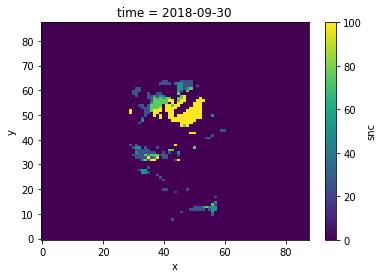

In [27]:
#plot the data for one date for checking:
snow_rutgers.snc.isel(time=620).plot()

In [28]:
# In the future, we should make the plots with cartopy!
# import cartopy.crs as ccrs
# from cartopy.util import add_cyclic_point

# data=snow_rutgers.snc.isel(time=0)
# ax = plt.subplot(projection=ccrs.PlateCarree())
# cyclic_data = add_cyclic_point(data)
# cyclic_data.plot.pcolormesh('lon', 'lat', ax=ax)

# # ax.scatter(lon, lat, transform=ccrs.PlateCarree());

# ax.coastlines()
# ax.gridlines(draw_labels=True)
# ax.set_global()

In [29]:
# Interpolation with CDO from polar to gaussian grid, on the LMDZ grid
filein=sourceData+'monthly_snow_rutgers.nc'
fileout=sourceData+'monthly_snow_rutgers_144x143.nc'
!cdo remapbil,mygrid $filein $fileout

cdo remapbil: Bilinear weights from curvilinear (88x88) to lonlat (144x143) grid
cdo remapbil:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 910cdo remapbil: Processed 4832256 values from 1 variable over 624 timesteps [0.62s 349MB]


<type 'instance'>


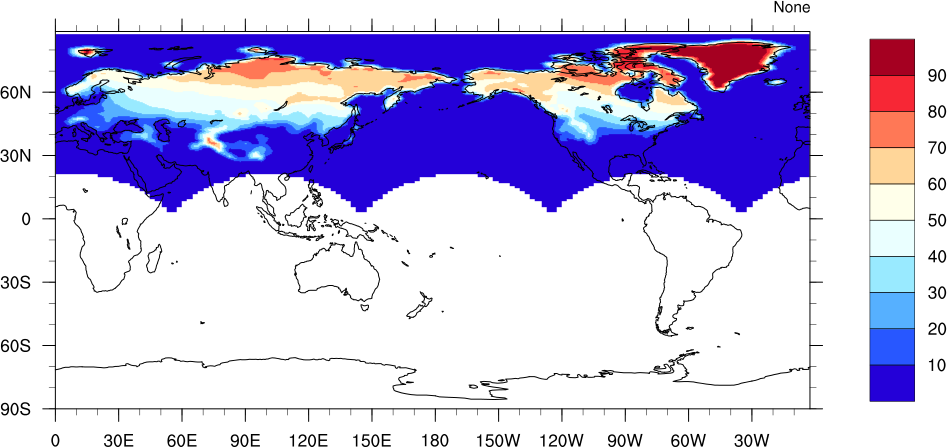

In [30]:
##Loading reference dataset and selecting period
##This is not the "elegant" way to do it, i am working on the creation of projec='ref_climatos' (Adding_access...ipynb example)
ref_rutgers = fds(fileout,variable='snc',period=str(first_year)+'-'+str(last_year))
print type(ref_rutgers)
cfile(ref_rutgers)
mean_ref_rutgers = clim_average(ref_rutgers,'ANM')
implot(mean_ref_rutgers)

In [31]:
# -- Compute the climatologies
clim_ipsl = clim_average(req_snow,'ANM')
clim_obs = clim_average(ref_rutgers,'ANM')
# -- Then, the bias map
rgrd_dat = regrid(clim_ipsl,clim_obs) # needed to have the data on the same grid and with the same masks
clim_bias = minus(rgrd_dat,clim_obs)

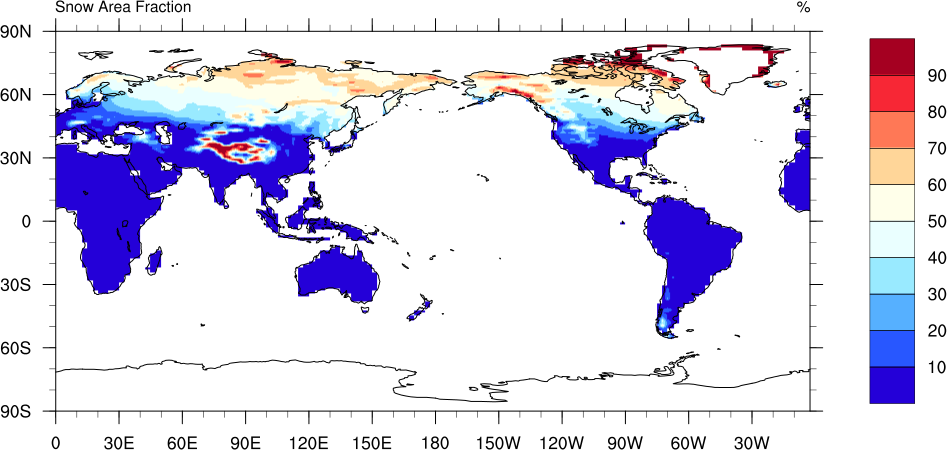

In [32]:
implot(clim_ipsl)

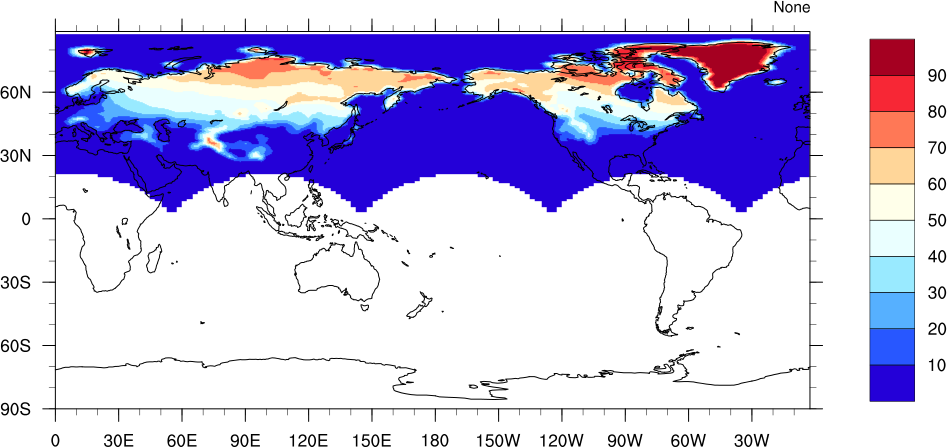

In [33]:
implot(clim_obs)

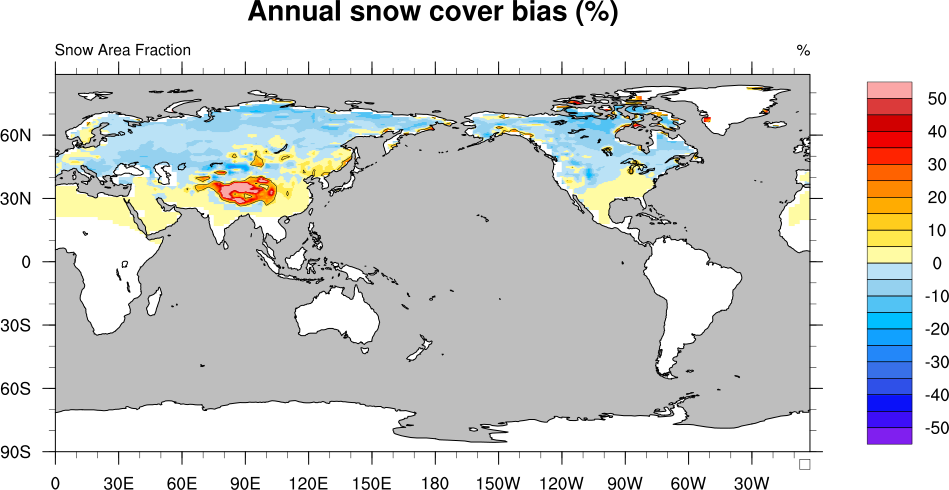

In [34]:
map = plot(clim_bias,title='Annual snow cover bias (%)', **plotting_specs)
# --> a map that you can easily customize.
iplot(map)

In [35]:
# DJF biases
# -- Compute the climatologies
clim_ipsl_DJF = clim_average(req_snow,'DJF')
clim_obs_DJF = clim_average(ref_rutgers,'DJF')
# -- Then, the bias map
rgrd_dat_DJF = regrid(clim_ipsl_DJF,clim_obs_DJF)
clim_bias_DJF = minus(rgrd_dat_DJF,clim_obs_DJF)
map_DJF = plot(clim_bias_DJF,title='DJF snow cover bias (%)', **plotting_specs)

In [36]:
# MAM biases
# -- Compute the climatologies
clim_ipsl_MAM = clim_average(req_snow,'MAM')
clim_obs_MAM = clim_average(ref_rutgers,'MAM')
# -- Then, the bias map
rgrd_dat_MAM = regrid(clim_ipsl_MAM,clim_obs_MAM)
clim_bias_MAM = minus(rgrd_dat_MAM,clim_obs_MAM)
map_MAM = plot(clim_bias_MAM,title='MAM snow cover bias (%)', **plotting_specs)

In [37]:
# JJA biases
# -- Compute the climatologies
clim_ipsl_JJA = clim_average(req_snow,'JJA')
clim_obs_JJA = clim_average(ref_rutgers,'JJA')
# -- Then, the bias map
rgrd_dat_JJA = regrid(clim_ipsl_JJA,clim_obs_JJA)
clim_bias_JJA = minus(rgrd_dat_JJA,clim_obs_JJA)
map_JJA = plot(clim_bias_JJA,title='JJA snow cover bias (%)', **plotting_specs)

In [38]:
# SON biases
# -- Compute the climatologies
clim_ipsl_SON = clim_average(req_snow,'SON')
clim_obs_SON = clim_average(ref_rutgers,'SON')
# -- Then, the bias map
rgrd_dat_SON = regrid(clim_ipsl_SON,clim_obs_SON)
clim_bias_SON = minus(rgrd_dat_SON,clim_obs_SON)
map_SON = plot(clim_bias_SON,title='SON snow cover bias (%)', **plotting_specs)

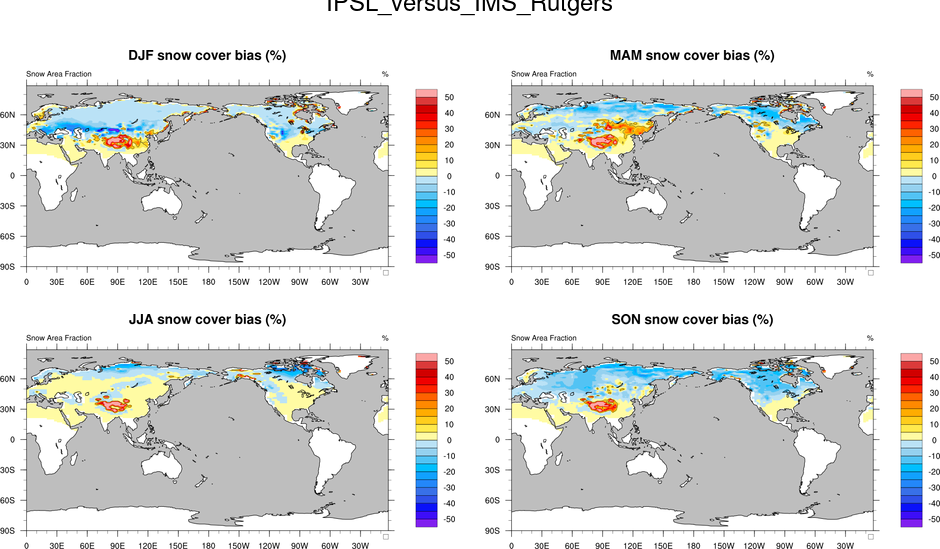

In [39]:
multiplot = cpage(fig_lines = [[map_DJF,map_MAM],[map_JJA,map_SON]],title='IPSL_versus_IMS_Rutgers')
iplot(multiplot)

In [40]:
#We save the pdf on my home directory:
cfile(cpage(fig_lines = [[map_DJF,map_MAM],[map_JJA,map_SON]],
      title='IPSL_versus_IMS_Rutgers'),
      target='/home/mmenegoz/travaux_martin/snow_IPSLCM6/IPSL_bias_rutgers.pdf')

'/home/mmenegoz/travaux_martin/snow_IPSLCM6/IPSL_bias_rutgers.pdf'